In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx

import sys; sys.path.insert(0, '..') # add parent folder path where discrepancies folder is

from discrepancies import datasets, pool, pool2graph, evaluation, discrepancies_intervals, pool2graph_cat_FJ2_2

RANDOM_STATE = 42

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
### Get data and fit a pool of classifiers on it

#X_train, X_test, y_train, y_test, scaler, feature_names, target_names, cat_names = datasets.get_dataset(dataset='adult-cat')
X_train, X_test, y_train, y_test, scaler, feature_names, target_names, cat_names = datasets.get_dataset(dataset='adult-cat', test_size=0.2)

print(X_train.shape, y_train.mean())
cont_names = list(set(feature_names) - set(cat_names))

taking only 3000 instances
(2400, 96) 0.22916666666666666


In [3]:

pool1 = pool.BasicPool()
pool1 = pool1.fit(X_train, y_train)

preds = pool1.predict(X_test)
from sklearn.metrics import f1_score
print({c: f1_score(y_test, preds[c]) for c in preds.columns})


p2g = pool2graph_cat_FJ2_2.pool2graph(X_train, y_train, pool1, k_init=3, categorical_names=cat_names)
#p2g = pool2graph.pool2graph(X_train, y_train, pool1, k_init=3)

p2g.fit(max_epochs=5)
print(len(p2g.G.nodes))

{'SVMrbf': 0.5345622119815668, 'RF50': 0.6083333333333333}


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5


24639


In [5]:
from discrepancies import discrepancies_intervals
intervals = discrepancies_intervals.get_discrepancies_intervals(p2g.G)
print(len(intervals))

4648


# Global analysis of the intervals

In [20]:
%load_ext autoreload

%autoreload 2
from discrepancies import analysis_global

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
### we work with that    
gda = analysis_global.GlobalDiscrepancyAnalyzer(p2g, pool1, intervals, X_train, cat_names)

Intervals amplitude dataset (self.amplitude_dataset): shape (4648, 96)
Input data preprocessed (self.X): shape (2400, 97)
Nodes dataset (self.nodes_dataset): shape (24639, 97)


### Most problematic features

For now, we evaluate separately the uncertainty associated to each feature for continuous and categorical features.
- For continuous features: Average range of the discrepancy interval along the feature
- For categorical features: proportion of intervals generated along the feature, normalized by the exposition in Xtrain --> pas sûr qu'il faille normaliser par ça... car intercalle = 2 pts, X_train= chaque pt


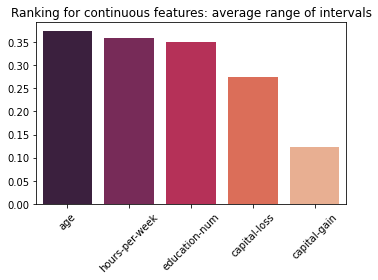

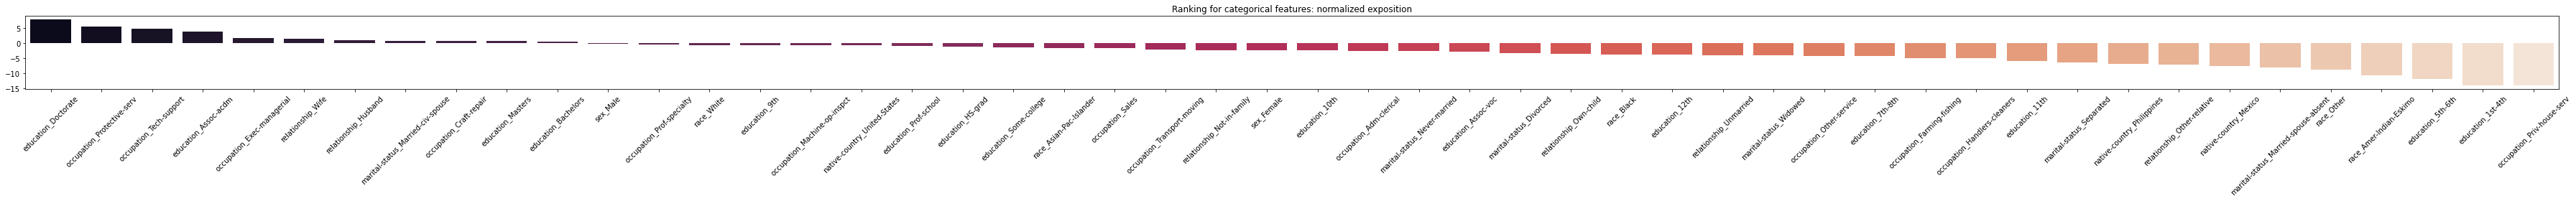

In [9]:
import seaborn as sns
from matplotlib import pyplot as plt

feat_imp = gda.get_global_discrepancy_importances(min_expo=10)
gda.plot_feature_importances()

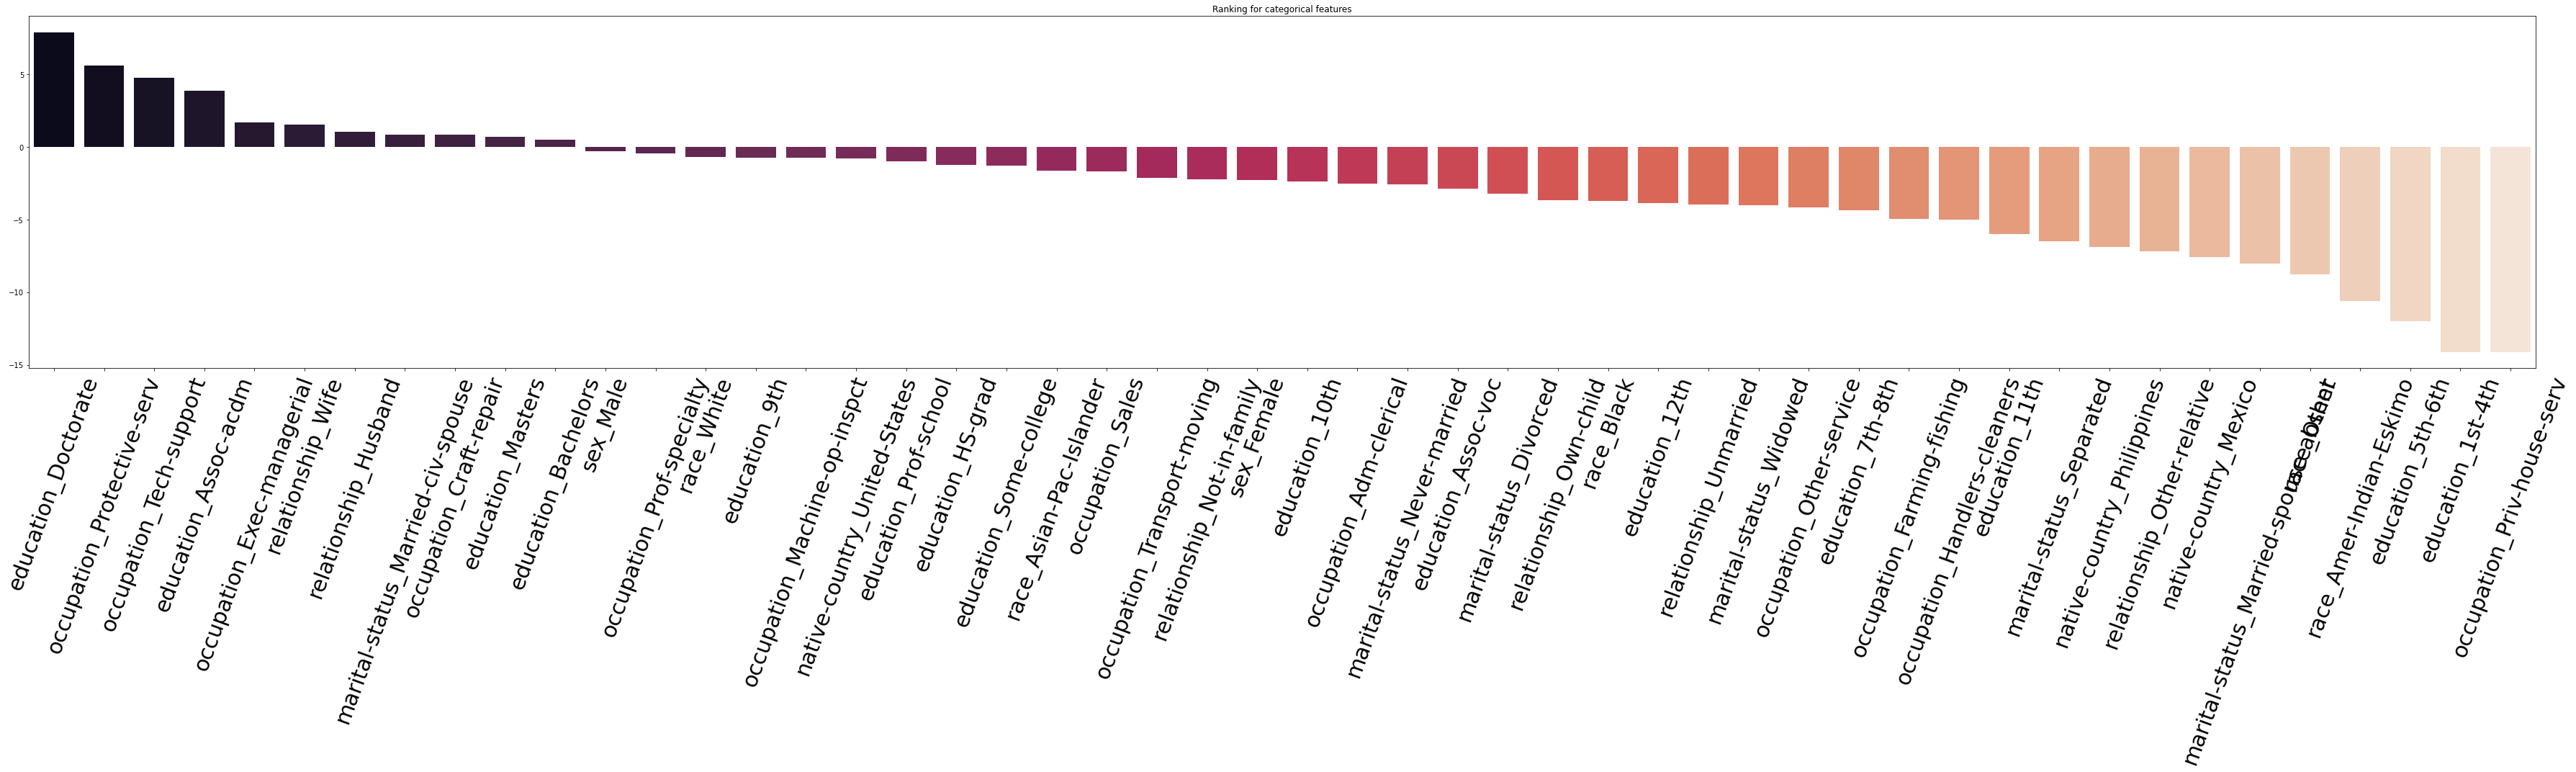

In [10]:
plt.figure(figsize=(len(feat_imp['categorical_features']),15))
plt.xticks(rotation=70, fontsize=30)
sns.barplot(data=pd.DataFrame(feat_imp['categorical_features']).T, palette="rocket")
plt.title("Ranking for categorical features")
plt.tight_layout()
#plt.savefig("./../../results/usecase_adult_featimp_cont.pdf")
plt.show()

## Important areas of discrepancy

In [22]:
gda.get_discrepancy_segments(X_exposition=X_train, y_exposition=y_train, min_expo=0.04, min_purity=0.3, min_purity_expo=0.0)

accuracy 0.8514737971078812
accuracy on given data 0.8866666666666667
====== SEGMENT 32 ======
=== Segment description:
decision node 0 : education-num > 0.4133424311876297)
decision node 24 : marital-status_Married-civ-spouse > 0.5)
decision node 28 : hours-per-week > 0.02125739213079214)
=== Segment characteristics
Segment exposition: 0.06625
Segment node population (proxy for size?): 0.10181589555826769
Segment purity: 0.519796585543044
Segment purity (X_expo): 0.33962264150943394
Accuracy of classifiers (X_expo) on segment: {'SVMrbf': 0.7567567567567567, 'RF50': 0.8731343283582089}
====== SEGMENT 31 ======
=== Segment description:
decision node 0 : education-num > 0.4133424311876297)
decision node 24 : marital-status_Married-civ-spouse > 0.5)
decision node 28 : hours-per-week <= 0.02125739213079214)
decision node 29 : age > 0.18135368824005127)
=== Segment characteristics
Segment exposition: 0.04791666666666667
Segment node population (proxy for size?): 0.04630348755501313
Segment 

In [ ]:
### Purity moyenne sur X_train
pool1.predict_discrepancies(X_train).mean()

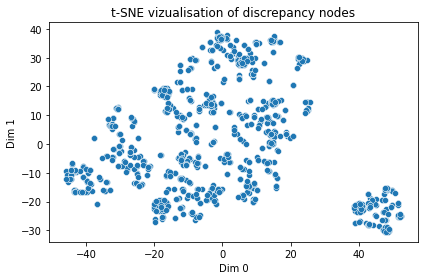

In [23]:

data = gda.disc_nodes_dataset.iloc[:1000, :]
#ici, chercher à accéder à la feuille du CART. colorer avec les zones affichées ci-dessus

from sklearn.manifold import TSNE
tsne = TSNE(perplexity=30, n_jobs=-1).fit_transform(data)
tsne = pd.DataFrame(tsne, columns=["Dim 0", "Dim 1"])
#tsne["cluster"] = clusters
sns.scatterplot(x="Dim 0", y="Dim 1", data=tsne)
plt.title("t-SNE vizualisation of discrepancy nodes")
plt.tight_layout()
#plt.savefig("./../../results/discussion_tsne_boston.pdf")

# TODO
- Categorical: quand on génère les faux jumeaux, garder en mémoire les couples des modalités: blond-brun, et le changement associé?
- TSNE: couleurs 
- relative size: devrait être nombre de noeuds de discrepancy dans la feuille sur le nombre de noeuds de discrepancy